# 6. Decision Trees and Ensemble Learning


This week, we'll talk about decision trees and tree-based ensemble algorithms

## 6.1 Credit risk scoring project

* Dataset: https://github.com/gastonstat/CreditScoring

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [119]:
from sklearn.metrics import make_scorer, roc_auc_score

## 6.2 Data cleaning and preparation

* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split

In [6]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [7]:
!wget $data

--2023-10-21 22:25:30--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: 'CreditScoring.csv.3'

     0K .......... .......... .......... .......... .......... 28% 1,12M 0s
    50K .......... .......... .......... .......... .......... 56% 4,15M 0s
   100K .......... .......... .......... .......... .......... 84% 2,69M 0s
   150K .......... .......... ........                        100% 9,54M=0,08s

2023-10-21 22:25:31 (2,28 MB/s) - 'CreditScoring.csv.3' saved [182489/182489]



In [8]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [9]:
df = pd.read_csv(data)

In [10]:
df.columns = df.columns.str.lower()

In [11]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [12]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

In [13]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

In [14]:
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

In [15]:
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

In [16]:
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

In [17]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [18]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [19]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [20]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   status     4455 non-null   object 
 1   seniority  4455 non-null   int64  
 2   home       4455 non-null   object 
 3   time       4455 non-null   int64  
 4   age        4455 non-null   int64  
 5   marital    4455 non-null   object 
 6   records    4455 non-null   object 
 7   job        4455 non-null   object 
 8   expenses   4455 non-null   int64  
 9   income     4421 non-null   float64
 10  assets     4408 non-null   float64
 11  debt       4437 non-null   float64
 12  amount     4455 non-null   int64  
 13  price      4455 non-null   int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 487.4+ KB


In [22]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   status     4454 non-null   object 
 1   seniority  4454 non-null   int64  
 2   home       4454 non-null   object 
 3   time       4454 non-null   int64  
 4   age        4454 non-null   int64  
 5   marital    4454 non-null   object 
 6   records    4454 non-null   object 
 7   job        4454 non-null   object 
 8   expenses   4454 non-null   int64  
 9   income     4420 non-null   float64
 10  assets     4407 non-null   float64
 11  debt       4436 non-null   float64
 12  amount     4454 non-null   int64  
 13  price      4454 non-null   int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 487.3+ KB


In [24]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [25]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [26]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [27]:
del df_train['status']
del df_val['status']
del df_test['status']

In [28]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


## 6.3 Decision trees

* How a decision tree looks like
* Training a decision tree 
* Overfitting
* Controlling the size of a tree

In [29]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [30]:
xi = df_train.iloc[0].to_dict()

In [31]:
df_train.iloc[0].to_dict()

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [32]:
assess_risk(xi)

'ok'

In [33]:
xi = df_train.iloc[-22].to_dict()

In [34]:
df_train.iloc[-22].to_dict()

{'seniority': 3,
 'home': 'parents',
 'time': 48,
 'age': 29,
 'marital': 'separated',
 'records': 'no',
 'job': 'fixed',
 'expenses': 35,
 'income': 108.0,
 'assets': 0.0,
 'debt': 0.0,
 'amount': 900,
 'price': 1263}

In [35]:
assess_risk(xi)

'default'

In [36]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [37]:
train_dicts[:2]

[{'seniority': 10,
  'home': 'owner',
  'time': 36,
  'age': 36,
  'marital': 'married',
  'records': 'no',
  'job': 'freelance',
  'expenses': 75,
  'income': 0.0,
  'assets': 10000.0,
  'debt': 0.0,
  'amount': 1000,
  'price': 1400},
 {'seniority': 6,
  'home': 'parents',
  'time': 48,
  'age': 32,
  'marital': 'single',
  'records': 'yes',
  'job': 'fixed',
  'expenses': 35,
  'income': 85.0,
  'assets': 0.0,
  'debt': 0.0,
  'amount': 1100,
  'price': 1330}]

In [38]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [39]:
X_train[:2]

array([[3.60e+01, 1.00e+03, 1.00e+04, 0.00e+00, 7.50e+01, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.40e+03, 1.00e+00, 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, 0.00e+00, 3.50e+01, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        8.50e+01, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        1.33e+03, 0.00e+00, 1.00e+00, 6.00e+00, 4.80e+01]])

In [40]:
dv.feature_names_

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

In [41]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [42]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [43]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6553274321280667

In [44]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [45]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [46]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [47]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



## 6.4 Decision tree learning algorithm

* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

In [48]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [49]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [50]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [51]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_left.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


In [52]:
from IPython.display import display

In [53]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



In [54]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [55]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [56]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [57]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


## 6.5 Decision trees parameter tuning

* selecting `max_depth`
* selecting `min_samples_leaf`

In [58]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.746
  10 -> 0.705
  15 -> 0.665
  20 -> 0.653
None -> 0.663


In [59]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [60]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [61]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.758
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.773  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

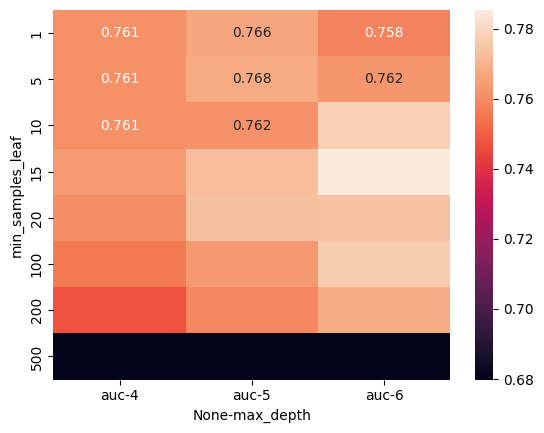

In [62]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [63]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [64]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- income <= 117.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  117.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class: 1
|

## 6.6 Ensembles and random forest

* Board of experts
* Ensembling models 
* Random forest - ensembling decision trees
* Tuning random forest

In [65]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [66]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

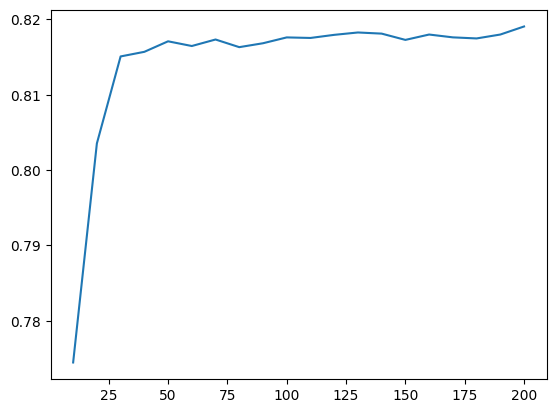

In [67]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [68]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [69]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

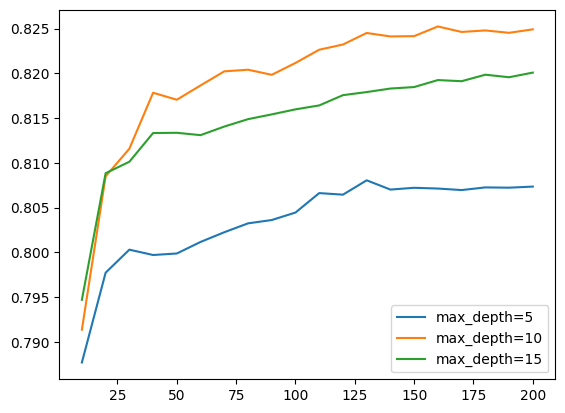

In [70]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [71]:
max_depth = 10

In [72]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [73]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

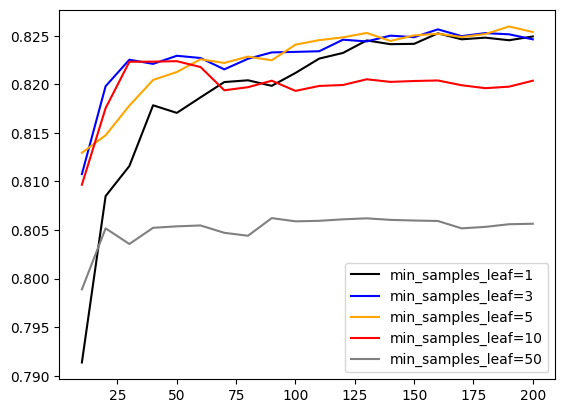

In [74]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [75]:
min_samples_leaf = 3

In [76]:
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=50,
                       random_state=1)

In [77]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

In [78]:
auc

0.8229365963527162

Other useful parametes:

* `max_features`
* `bootstrap`

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## 6.7 Gradient boosting and XGBoost

* Gradient boosting vs random forest
* Installing XGBoost
* Training the first model
* Performance monitoring
* Parsing xgboost's monitoring output

https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters

In [79]:
features = dv.get_feature_names_out()
list(features)

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

In [80]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(features))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(features))

In [81]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [82]:
y_pred = model.predict(dval)

In [83]:
roc_auc_score(y_val, y_pred)

0.8065256351262986

In [84]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [85]:
# Create a DMatrix from your dataset (assuming you have it loaded as 'dtrain')
# Watchlist for evaluation
watchlist = [(dtrain, 'train'), (dval, 'validation')]  # Add validation set if available

In [138]:
watchlist

[(<xgboost.core.DMatrix at 0x18b089ae9d0>, 'train'),
 (<xgboost.core.DMatrix at 0x18b089ae9a0>, 'validation')]

In [86]:
# Lists to store evaluation results
evals_result = {}

In [87]:
# Train the model and monitor the training process
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,
    verbose_eval=5,
    evals=watchlist,
    evals_result=evals_result,  # Store evaluation results
)

[0]	train-auc:0.86730	validation-auc:0.77938
[5]	train-auc:0.93086	validation-auc:0.80858
[10]	train-auc:0.95447	validation-auc:0.80851
[15]	train-auc:0.96554	validation-auc:0.81334
[20]	train-auc:0.97464	validation-auc:0.81729
[25]	train-auc:0.97953	validation-auc:0.81686
[30]	train-auc:0.98579	validation-auc:0.81543
[35]	train-auc:0.99011	validation-auc:0.81206
[40]	train-auc:0.99421	validation-auc:0.80922
[45]	train-auc:0.99548	validation-auc:0.80842
[50]	train-auc:0.99653	validation-auc:0.80918
[55]	train-auc:0.99765	validation-auc:0.81114
[60]	train-auc:0.99817	validation-auc:0.81172
[65]	train-auc:0.99887	validation-auc:0.80798
[70]	train-auc:0.99934	validation-auc:0.80870
[75]	train-auc:0.99965	validation-auc:0.80555
[80]	train-auc:0.99979	validation-auc:0.80549
[85]	train-auc:0.99988	validation-auc:0.80374
[90]	train-auc:0.99993	validation-auc:0.80409
[95]	train-auc:0.99996	validation-auc:0.80548
[100]	train-auc:0.99998	validation-auc:0.80509
[105]	train-auc:0.99999	validation-

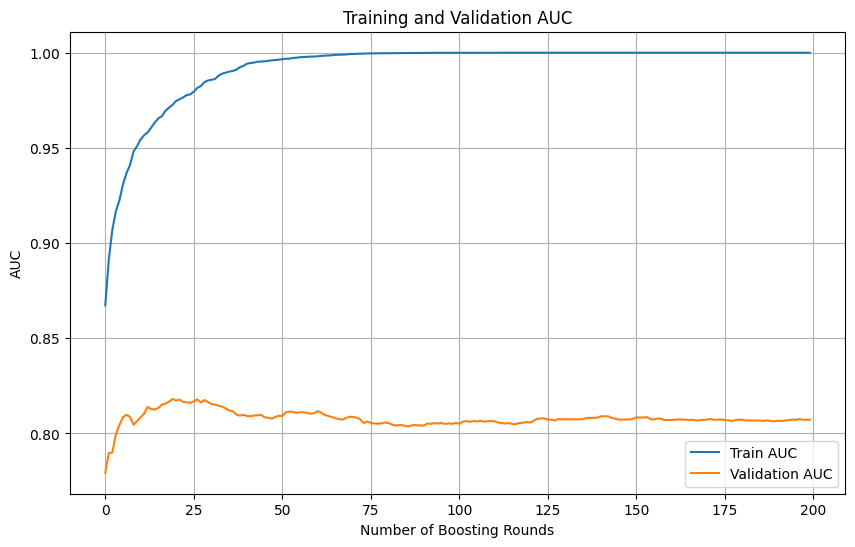

In [88]:
# Extract and plot evaluation results
train_metric = evals_result['train']['auc']
validation_metric = evals_result['validation']['auc']
plt.figure(figsize=(10, 6))
plt.plot(train_metric, label='Train AUC')
plt.plot(validation_metric, label='Validation AUC')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()
plt.grid()
plt.show()

In [96]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [121]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'eval_metric': ['auc'],
    'eta': [0.1, 0.3, 0.5],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

In [147]:
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3],  # Learning rate
    'max_depth': [3, 4, 5, 6, 7],  # Maximum tree depth
    'min_child_weight': [1, 2, 3, 4, 5],  # Minimum sum of instance weight
    'tree_method': ['auto', 'exact', 'approx', 'hist'],  # Tree construction method
    'lambda': [0, 0.001, 0.01, 0.1, 1],  # L2 regularization term
    'alpha': [0, 0.001, 0.01, 0.1, 1],  # L1 regularization term
    'grow_policy': ['depthwise', 'lossguide'],  # Tree growth method
    'scale_pos_weight': [1, 2, 3, 4, 5],  # Adjust for class imbalance
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Fraction of samples used for training
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Fraction of features used for training
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # Minimum loss reduction to partition a leaf node
}

In [193]:
param_grid = {
    'eval_metric': ['auc'],
    'eta': [0.01, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum tree depth
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight
    'lambda': [0.001, 0.1, 1],  # L2 regularization term
    # 'alpha': [0.001, 0.1, 1],  # L1 regularization term
    'scale_pos_weight': [1, 2, 3],  # Adjust for class imbalance
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for training
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for training
}


In [194]:
# Create a custom scorer using ROC AUC
custom_scorer = make_scorer(roc_auc_score, greater_is_better=True)

In [195]:
# Create the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    nthread=-1,
    seed=1,
    verbosity=2
)

In [196]:
# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [197]:
# Fit the grid search with early stopping
grid_search.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=10
)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[0]	validation_0-auc:0.73342
[10]	validation_0-auc:0.79177
[20]	validation_0-auc:0.80643
[30]	validation_0-auc:0.81789
[40]	validation_0-auc:0.82438
[50]	validation_0-auc:0.83009
[60]	validation_0-auc:0.83186
[70]	validation_0-auc:0.83398
[80]	validation_0-auc:0.83519
[90]	validation_0-auc:0.83594
[99]	validation_0-auc:0.83673


c:\users\konutech\ml-zoomcamp\machine-learning-zoomcamp\venv\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'eta': [0.01, 0.1, 0.2], 'eval_metric': ['auc'],
                         'lambda': [0.001, 0.1, 1], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3, 5],
                         'scale_pos_weight': [1, 2, 3],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc', verbose=2)

In [198]:
# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'colsample_bytree': 0.9, 'eta': 0.1, 'eval_metric': 'auc', 'lambda': 1, 'max_depth': 3, 'min_child_weight': 3, 'scale_pos_weight': 1, 'subsample': 0.8}


In [199]:
# Train the final model with the best hyperparameters
final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=200,
    verbose_eval=10,
    evals=watchlist,
    evals_result=evals_result,
    early_stopping_rounds=10
)

[0]	train-auc:0.76696	validation-auc:0.72707
[10]	train-auc:0.84973	validation-auc:0.80091
[20]	train-auc:0.86914	validation-auc:0.81639
[30]	train-auc:0.88173	validation-auc:0.82159
[40]	train-auc:0.89150	validation-auc:0.82735
[50]	train-auc:0.89905	validation-auc:0.82979
[60]	train-auc:0.90477	validation-auc:0.83078
[70]	train-auc:0.90851	validation-auc:0.83147
[80]	train-auc:0.91242	validation-auc:0.83230
[90]	train-auc:0.91626	validation-auc:0.83301
[100]	train-auc:0.92027	validation-auc:0.83532
[110]	train-auc:0.92321	validation-auc:0.83597
[120]	train-auc:0.92710	validation-auc:0.83497


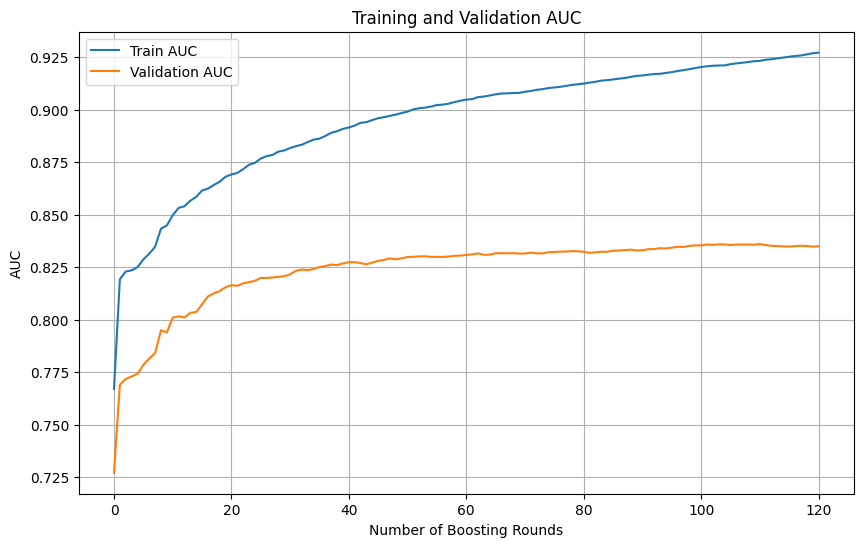

In [200]:
# Extract and plot evaluation results
train_metric = evals_result['train']['auc']
validation_metric = evals_result['validation']['auc']
plt.figure(figsize=(10, 6))
plt.plot(train_metric, label='Train AUC')
plt.plot(validation_metric, label='Validation AUC')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()
plt.grid()
plt.show()

## FEATURE IMPORTANCE

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [201]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,
    verbose_eval=5,
    evals=watchlist
)

In [202]:
s = output.stdout

In [203]:
print(s[:200])

[0]	train-auc:0.86730	validation-auc:0.77938
[5]	train-auc:0.93086	validation-auc:0.80858
[10]	train-auc:0.95447	validation-auc:0.80851
[15]	train-auc:0.96554	validation-auc:0.81334
[20]	train-auc:0.9


In [204]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [205]:
df_score = parse_xgb_output(output)

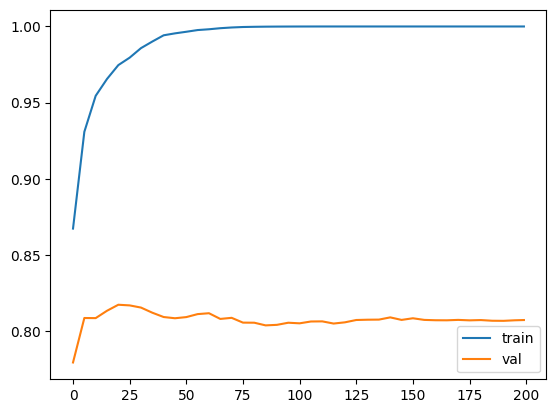

In [206]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

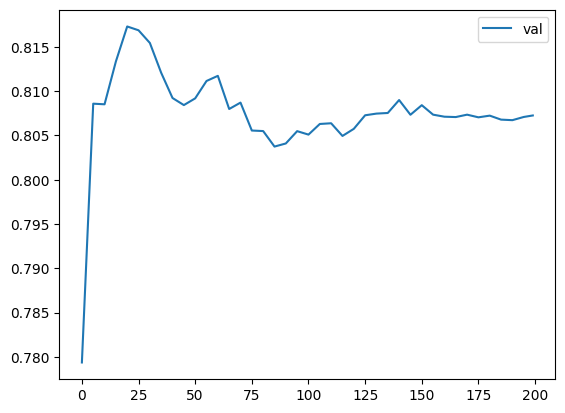

In [207]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## 6.8 XGBoost parameter tuning

Tuning the following parameters:

* `eta`
* `max_depth`
* `min_child_weight`


In [208]:
scores = {}

In [209]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [210]:
scores = {}

In [211]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [212]:
scores = {}

In [213]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [214]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [215]:
del scores['max_depth=10']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


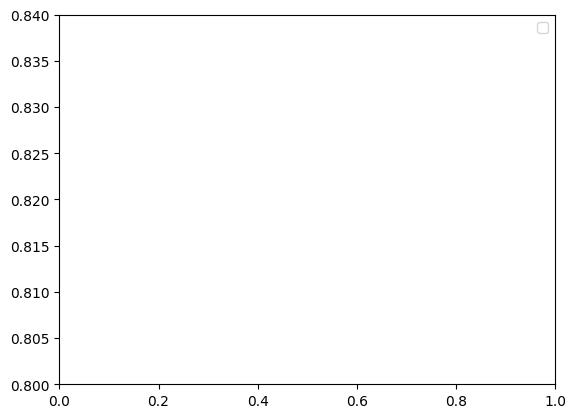

In [216]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

In [217]:
scores = {}

In [218]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [219]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

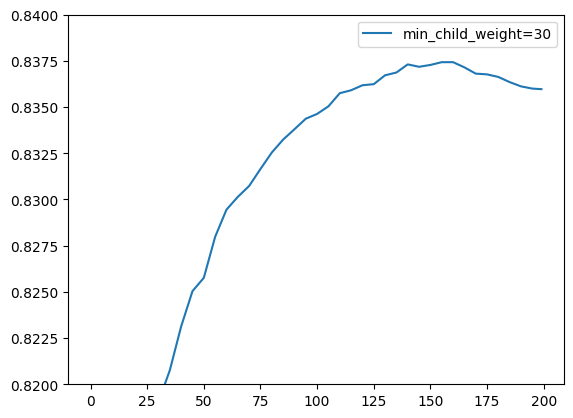

In [220]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

In [221]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:

* `subsample` and `colsample_bytree`
* `lambda` and `alpha`

## 6.9 Selecting the final model

* Choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

In [222]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [223]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7850954203095104

In [224]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [225]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [226]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [227]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8309347073212081

In [228]:
df_full_train = df_full_train.reset_index(drop=True)

In [229]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [230]:
del df_full_train['status']

In [231]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [233]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=list(dv.get_feature_names_out()))

dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))

In [234]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [235]:
y_pred = model.predict(dtest)

In [236]:
roc_auc_score(y_test, y_pred)

0.8289367577342261

# MY MODEL

In [246]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(features))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(features))

In [247]:
dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))

In [248]:
xgb_params = {
    'colsample_bytree': 0.9,
    'eta': 0.1,
    'eval_metric': 'auc',
    'lambda': 1,
    'max_depth': 3,
    'min_child_weight': 3,
    'scale_pos_weight': 1,
    'subsample': 0.8
}

In [249]:
model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [250]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8330477585914606

In [251]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8196813449978007

In [258]:
import numpy as np

# Assuming y_prob is your array of predicted probabilities
threshold = 0.5  # Set the threshold

# Convert probabilities to binary class predictions
y_pred = np.where(y_pred > threshold, 1, 0)

# Now you can compute classification metrics like the F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')


F1 Score: 0.5657


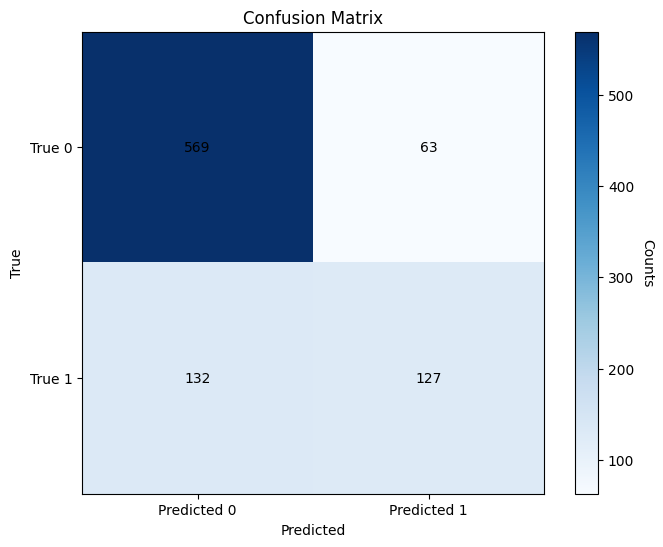

In [269]:
import matplotlib.pyplot as plt
import numpy as np

# Example confusion matrix (replace with your actual confusion matrix)
cm = np.array(confusion_matrix(y_test, y_pred))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a heatmap
im = ax.imshow(cm, cmap="Blues")

# Show all ticks and label them
ax.set_xticks(np.arange(len(cm[0])))
ax.set_yticks(np.arange(len(cm)))
ax.set_xticklabels(["Predicted 0", "Predicted 1"])
ax.set_yticklabels(["True 0", "True 1"])

# Loop over data dimensions and create text annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Display the color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Counts", rotation=-90, va="bottom")

# Set labels for x and y axis
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

plt.title("Confusion Matrix")

# Display the heatmap
plt.show()


## 6.10 Summary

* Decision trees learn if-then-else rules from data.
* Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
* Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
* Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting. 

## 6.11 Explore more

* For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
* For random forest, there are more parameters that we can tune. Check `max_features` and `bootstrap`.
* There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in `ExtraTreesClassifier`. Try it for this project.
* XGBoost can deal with NAs - we don't have to do `fillna` for it. Check if not filling NA's help improve performance.
* Experiment with other XGBoost parameters: `subsample` and `colsample_bytree`.
* When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for [random forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) (it's the same for plain decision trees) and for [xgboost](https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost)
* Trees can also be used for solving the regression problems: check `DecisionTreeRegressor`, `RandomForestRegressor` and the `objective=reg:squarederror` parameter for XGBoost.